# Setup

In [1]:
!brew install libomp    # might help if getting an OSERROR: dlopen...

==> Downloading https://formulae.brew.sh/api/formula.jws.json
#=#=-#  #                                                                      
==> Downloading https://formulae.brew.sh/api/cask.jws.json

To reinstall 16.0.6, run:
  brew reinstall libomp


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

from variance_reduction.diff_in_means import DifferenceInMeans
from variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from variance_reduction.mlrate import MLRATE, AltMLRATE
from variance_reduction.cupac import CUPAC
from variance_reduction.doubly_robust import DoublyRobustEstimator
from variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll, VREvaluationGrid
from variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted

# increase globally font size of matplotlib plots
plt.rcParams.update({'font.size': 12})

# increase globally font size of matplotlib plots titles
plt.rcParams.update({'axes.titlesize': 16})


In [4]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [5]:
example_data = dgp(10000, 10)

In [6]:
pre_exp_example_data = dgp(10000,10)
pre_exp_example_data = pre_exp_example_data.loc[pre_exp_example_data['T']==0]

# Variance Reduction methods

We implement the following methods in classes:
- `DifferenceInMeans` - the baseline method, no variance reduction
- `MultivariateRegression` - multivariate regression
- `MultivariateRegressionAdjustment` - multivariate regression adjustment
- `CUPED` - CUPED
- `MultivariateCUPED` - multivariate CUPED
- `CUPAC` - CUPAC
- `MLRATE` - MLRATE
- `DoublyRobustEstimator` - doubly robust estimator

All these methods are children of an abstract `VarianceReductionMethod` class, which provides a common interface for all methods. This allows for easy comparison of the methods and for easy evaluation of their performance.

To perform estimation we first instantiate a method:

In [5]:
estimator = MultivariateCUPED()

And then we can apply the method to data:

In [6]:
estimator = estimator.fit(data=example_data,
                          treatment_column='T',
                          target_column='Y',
                          covariate_columns=['X1', 'X2', 'X3'])


... and extract statistics of interest:

In [7]:
print("Estimate:", "%.3f" % estimator.estimate)
print("CI Lower:", "%.3f" % estimator.conf_int_95[0])
print("CI Upper:", "%.3f" % estimator.conf_int_95[1])
print("P-value:", "%.3f" % estimator.p_value)
print("Variance Reduction Rate:", "%.3f" % estimator.variance_reduction_rate)

Estimate: 1.410
CI Lower: 0.334
CI Upper: 2.485
P-value: 0.010
Variance Reduction Rate: 0.795


Note that other method may require different parameters when calling the `fit` method.


Also note that, the methods assume that the data has been preprocessed such that it does not contain any missing values, the columns are numerical and the treatment columns is binary (0 -- control, 1 -- treatment).

# Evaluation of variance reduction methods

At the moment the library provides 3 evaluation tools:
- `VREvaluation` - for evaluating a single variance reduction method.
- `VREvaluationAll` - for evaluating and comparing multiple variance reduction methods.
- `VREvaluationGrid` - for evaluating and comparing multiple variance reduction methods on a grid of parameters.

## Evaluation of a single method

Performing an evaluation requires the definition of a method-parameters map:

In [8]:
MLRATE_params_map = {
    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['X1', 'X6', 'X7', 'X8'],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    }
}

Then we initialize the evaluator with the method we are interested in:

In [9]:
mlrate_evaluation = VREvaluation(MLRATE)

And we can proceed to run the evaluation:

In [10]:
mlrate_evaluation = mlrate_evaluation.run(data=example_data,
                                          treatment_column='T',
                                          target_column='Y',
                                          true_ate=diff_in_means(example_data, 'T', 'Y'),
                                          method_params_map=MLRATE_params_map,
                                          verbose=True,
                                          n_bootstrap=100)

Running MLRATE...


100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


We present the results of the evaluation in a table:

In [11]:
mlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,MLRATE,1.466942,"(0.4108964866663161, 2.794770016185514)",-0.904045,"(-1.9600904518102464, 0.42378307770895146)",0.110715,"(6.715772254854897e-05, 0.5474013162143926)",0.74,0.690795


... or in a plot:

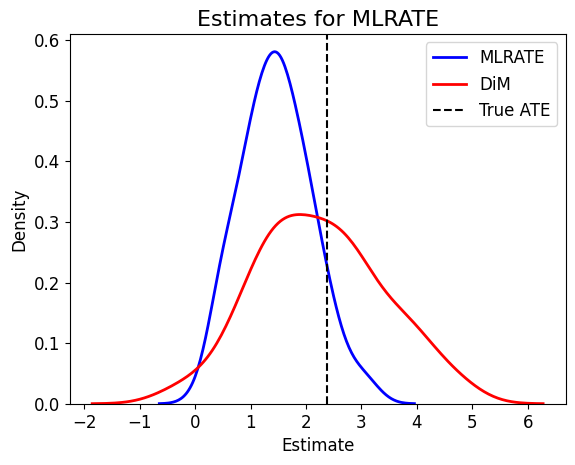

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for MLRATE'}, xlabel='Estimate', ylabel='Density'>)

In [12]:
mlrate_evaluation.plot(plot_what='estimates')

## Comparison of mutliple methods

The flow of evaluation and comparison of many variance reduction methods is same as for a single method with a few small differences.

As before we start with defining the method-parameters map

In [13]:
method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'MultivariateRegression': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_example_data,
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model_regression': LGBMRegressor
        
    }

}

Then we instantiate the appropriate class with all methods we wish to compare:

In [14]:
all_evaluation = VREvaluationAll([DifferenceInMeans,
                                 MultivariateRegression,
                                 MultivariateRegressionAdjusted,
                                 CUPED,
                                 MultivariateCUPED,
                                 CUPAC,
                                 MLRATE,
                                 DoublyRobustEstimator])

We perform the evaluation by calling `run_all`

In [ ]:
all_evaluation = all_evaluation.run_all(data=example_data,
                                        treatment_column='T',
                                        target_column='Y',
                                        true_ate=diff_in_means(example_data, 'T', 'Y'),
                                        method_params_map=method_params_map,
                                        verbose=True,
                                        n_bootstrap=100)

... and present the results in a table 

In [16]:
all_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,2.290795,"(-0.19834555649185576, 4.7995587005076725)",-0.080192,"(-2.5693324949684184, 2.4285717620311096)",0.181081,"(7.671862247797499e-05, 0.8702258390344402)",0.91,0.000000
1,MultivariateRegression,1.267831,"(0.15337028436861397, 2.477852916144949)",-1.103156,"(-2.2176166541079487, 0.10686597766838679)",0.163494,"(0.00024455851656093544, 0.8191843105087028)",0.63,0.758141
2,MultivariateRegressionAdjusted,1.266614,"(0.15276252609102095, 2.47747330983457)",-1.104373,"(-2.2182244123855415, 0.10648637135800723)",0.163652,"(0.000245336588923501, 0.8183166895169375)",0.63,0.758169
3,CUPED,1.468273,"(0.46244728526414675, 2.7461541293028358)",-0.902714,"(-1.9085396532124157, 0.37516719082627337)",0.107228,"(6.559874238584376e-05, 0.5029249973058764)",0.73,0.754004
4,MultivariateCUPED,1.266207,"(0.15317326714667773, 2.4744664381718344)",-1.104780,"(-2.2178136713298846, 0.10347949969527177)",0.163592,"(0.0002461313517581031, 0.8192599537704208)",0.63,0.758811
5,CUPAC,1.539097,"(0.3946304450098147, 2.8587016628797564)",-0.831890,"(-1.976356493466748, 0.4877147244031938)",0.100173,"(3.8053004093405136e-05, 0.5706824347883394)",0.77,0.749335
6,MLRATE,1.099003,"(0.24260148623902433, 2.191471661155754)",-1.271984,"(-2.1283854522375383, -0.17951527732080858)",0.182244,"(0.0006731871743997623, 0.7048159687199129)",0.48,0.832596
7,DoublyRobustEstimator,1.222519,"(0.1784464683008422, 2.437781870013517)",-1.148468,"(-2.1925404701757203, 0.06679493153695432)",None,None,0.57,0.793427


... as well as on a plot:

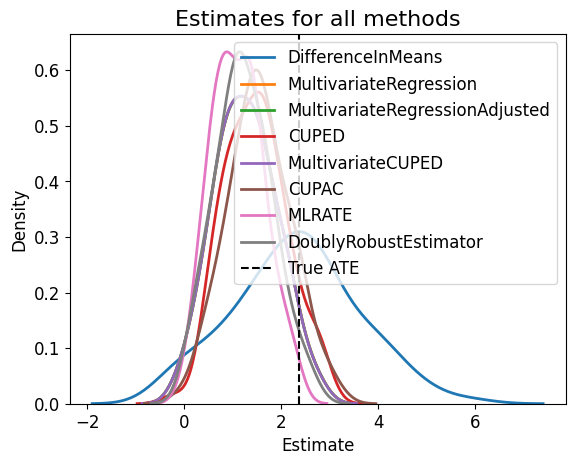

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [17]:
all_evaluation.plot(plot_what='estimates')

## Evaluation of methods on a grid of parameters

Finally we can compare how all of our methods react to changes in the scope of pre-experiment data used and the models used for training the ML models.

We begin for defining the base method-parameters map, which contains the parameters that will not change:

In [18]:
base_method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': None
    },

    'MultivariateRegression': {
        'covariate_columns': None
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': None
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_example_data,
        'covariate_columns': None,
        'model': None,
        'model_init_config': None,
        'model_fit_config': None
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': None,
        'model': None,
        'model_init_config': None,
        'model_fit_config': None
    },

    'DoublyRobustEstimator': {
        'covariate_columns': None,
        'model_regression': None
        
    }

}

To create the parameters grid that we will evaluate over, we use the `generate_parameters_grid` static method of the `VREvaluationGrid`:

In [19]:
parameter_grid = VREvaluationGrid.generate_parameters_grid(
                         base_methods_params_map=base_method_params_map,
                         covariate_columns_list = [['X1'], ['X1', 'X2'], ['X1', 'X2', 'X3']],
                         models = [ElasticNet, LGBMRegressor],
                         model_init_configs = [{}, {}],
                         model_fit_configs = [{}, {}])

Next, we initialize and finally run the evaluation over the grid

In [ ]:
all_evaluation_grid = VREvaluationGrid([DifferenceInMeans, MultivariateRegression, MultivariateRegressionAdjusted, CUPED, CUPAC, MLRATE])
all_evaluation_grid = all_evaluation_grid.run(data=example_data, 
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_grid=parameter_grid,
                                      true_ate=diff_in_means(example_data, 'T', 'Y'))

The results may be plotted on a plot:

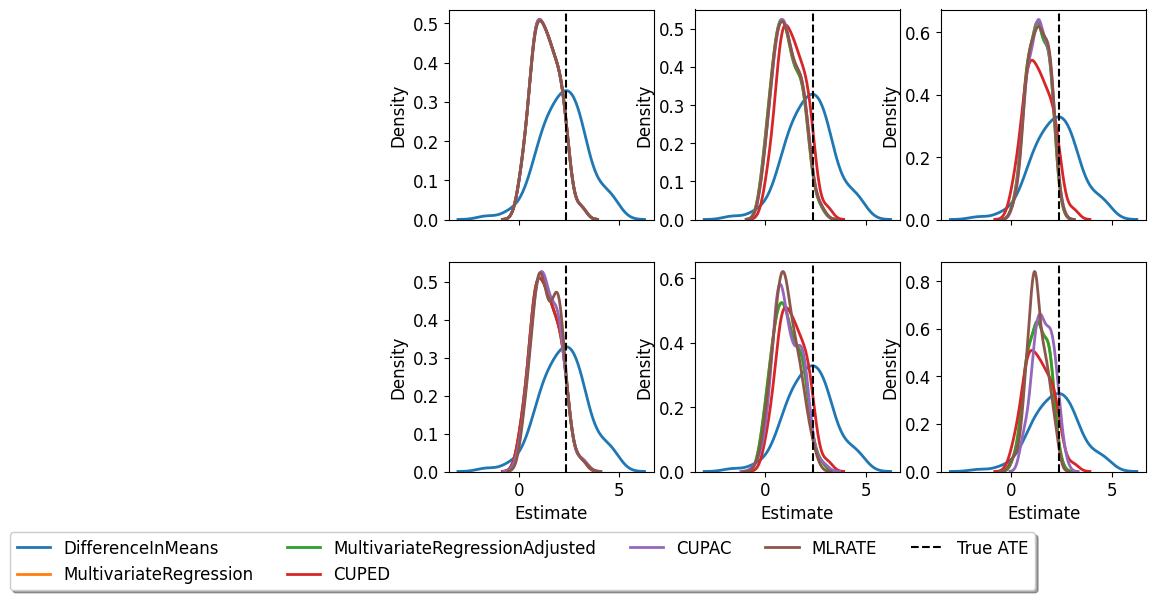

In [21]:
all_evaluation_grid.plot_grid()